Execute the preliminaries for downloading data and finding a suitable pair for pair trading.

Please re-execute if `params.py` is modified.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import json
import numpy as np
import pandas as pd
from params import *

from tqdm import tqdm
from itertools import combinations
from utils.read2df import read2df
from utils.cointncorr import CointnCorr

In [2]:
# %%capture
if symbols is None:
    !python binance-public-data/python/download-kline.py \
        -i {" ".join(list(freqs.keys()))} -startDate {start_date} -endDate {end_date} -t spot -skip-daily 1
else:
    !python binance-public-data/python/download-kline.py \
        -s {" ".join(symbols)} -i {" ".join(list(freqs.keys()))} -startDate {start_date} -t spot -skip-daily 1

Found 3 symbols
[1/3] - start download monthly BTCUSDT klines 

file already exists! C:\Users\hyan212\backtrader-crypto-rl\binance-public-data\python\data/spot/monthly/klines/BTCUSDT/1m/BTCUSDT-1m-2023-10.zip

file already exists! C:\Users\hyan212\backtrader-crypto-rl\binance-public-data\python\data/spot/monthly/klines/BTCUSDT/1m/BTCUSDT-1m-2023-11.zip

file already exists! C:\Users\hyan212\backtrader-crypto-rl\binance-public-data\python\data/spot/monthly/klines/BTCUSDT/1m/BTCUSDT-1m-2023-12.zip

file already exists! C:\Users\hyan212\backtrader-crypto-rl\binance-public-data\python\data/spot/monthly/klines/BTCUSDT/3m/BTCUSDT-3m-2023-10.zip

file already exists! C:\Users\hyan212\backtrader-crypto-rl\binance-public-data\python\data/spot/monthly/klines/BTCUSDT/3m/BTCUSDT-3m-2023-11.zip

file already exists! C:\Users\hyan212\backtrader-crypto-rl\binance-public-data\python\data/spot/monthly/klines/BTCUSDT/3m/BTCUSDT-3m-2023-12.zip

file already exists! C:\Users\hyan212\backtrader-crypto-rl\b

In [3]:
'''
Read the downloaded OHLCV data into `pandas` dataframe
'''

# dfs = read2df(symbols, freqs)
dfs = read2df(symbols, freqs, marketType='spot')

# have a preview
dfs[0]

,time,open,high,low,close,volume,tic,itvl,datetime
0,1696118459999,25534.98,25534.98,25530.88,25534.42,0.17106,BTCEUR,1m,2023-10-01 00:00:59.999
1,1696118459999,22268.92,22268.92,22268.92,22268.92,0.00000,BTCGBP,1m,2023-10-01 00:00:59.999
2,1696118459999,26962.57,26962.57,26960.13,26960.13,3.11266,BTCUSDT,1m,2023-10-01 00:00:59.999
3,1696118519999,25535.27,25535.27,25529.86,25529.86,0.03995,BTCEUR,1m,2023-10-01 00:01:59.999
4,1696118519999,22268.92,22268.92,22268.92,22268.92,0.00000,BTCGBP,1m,2023-10-01 00:01:59.999
...,...,...,...,...,...,...,...,...,...
385015,1703818739999,35624.34,35697.11,35582.30,35697.11,0.07094,BTCGBP,1m,2023-12-29 02:58:59.999
385016,1703818739999,42560.54,42570.00,42557.00,42561.81,18.81898,BTCUSDT,1m,2023-12-29 02:58:59.999
385017,1703818799999,38506.92,38506.92,38506.92,38506.92,0.00439,BTCEUR,1m,2023-12-29 02:59:59.999
385018,1703818799999,35747.92,35986.75,35747.92,35986.75,0.00599,BTCGBP,1m,2023-12-29 02:59:59.999


In [4]:
'''
Set data before `trade_data` as training data, after `trade_data` is trade_data
'''

trains, tests = [], []
for i in range(len(dfs)):
    trains.append(dfs[i][(dfs[i]['datetime'] > start_date) & (dfs[i]['datetime'] < trade_date)].reset_index(drop=True))
    tests.append(dfs[i][(dfs[i]['datetime'] >= trade_date) & (dfs[i]['datetime'] < end_date)].reset_index(drop=True))

In [5]:
'''
Find the best pair
'''

import pickle

tables = CointnCorr(trains, freqs).tabulate()
cointncorrtxt = f"result/gridsearch/cointncorr.txt"

os.remove(f"{cointncorrtxt}") if os.path.exists(f"{cointncorrtxt}") else None

with open(cointncorrtxt, "w+") as f:
    for k, v in tables.items():
        f.write(f"{k}\n")
        f.write(f"{v}\n\n")
f.close()

best_value = 0
for key in tables.keys():
    for freq in freqs:
        rel = tables[key].at['coint', freq]*3 + tables[key].at['corr', freq]
        if rel > best_value:
            best_value = rel
            best_pair = key
            best_freq = freq

print("===========================================")
print(f"Best trading pairs shall be: {best_pair} under {best_freq} interval")
print(f"the coint is {round(tables[best_pair].at['coint', best_freq]*100, 2)}%")
print(f"and the corr is {round(tables[best_pair].at['corr', best_freq],3)}")
print("===========================================")

cointncorr = best_pair.split("_"), best_freq

with open('result/cointncorr.pickle', 'wb') as pk:
    pickle.dump(cointncorr, pk)

Best trading pairs shall be: BTCEUR_BTCGBP under 1m interval
the coint is 56.67%
and the corr is 0.876


# Graphs

In [6]:
leg0 = dfs[0][dfs[0]['tic']==best_pair.split("_")[0]]
leg1 = dfs[0][dfs[0]['tic']==best_pair.split("_")[1]]

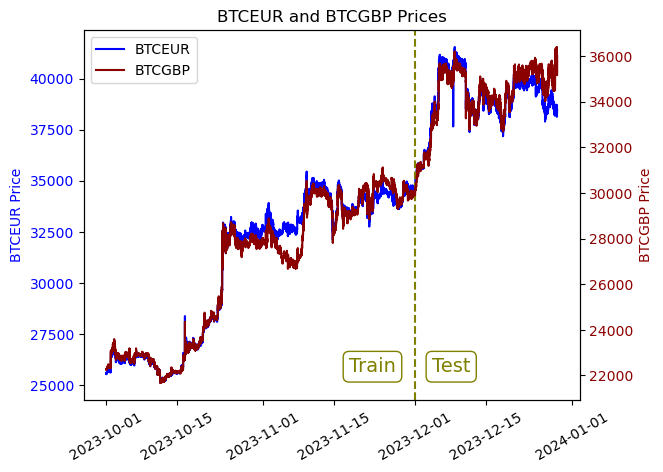

In [7]:
import matplotlib.pyplot as plt

# Create a figure and axis objects
fig, ax1 = plt.subplots()

# Plot data from leg0 on the first subplot
ax1.plot(leg0['datetime'], leg0['close'], color='blue', label='BTCEUR')
# ax1.set_xlabel('Datetime')
ax1.set_ylabel('BTCEUR Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot data from leg1 on the second subplot
ax2.plot(leg1['datetime'], leg1['close'], color='darkred', label='BTCGBP')
ax2.set_ylabel('BTCGBP Price', color='darkred')
ax2.tick_params(axis='y', labelcolor='darkred')

ax1.set_xticklabels(ax1.get_xticklabels(), rotation=30)

# Add legend for both subplots
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# Add a vertical line at x="2023-10-01"
vertical_line_date = datetime.strptime("2023-12-01", "%Y-%m-%d")
ax1.axvline(x=datetime.strptime("2023-12-01", "%Y-%m-%d"), color='olive', linestyle='--')

# Add text boxes for "Train" and "Test" labels
ax1.text(
    datetime.strptime("2023-11-18", "%Y-%m-%d"), ax1.get_ylim()[1]*0.6, "Train", 
    ha='left', va='bottom', fontsize=14, color='olive',
    bbox=dict(facecolor='white', edgecolor='olive', boxstyle='round'))
ax1.text(
    datetime.strptime("2023-12-12", "%Y-%m-%d"), ax1.get_ylim()[1]*0.6, "Test", 
    ha='right', va='bottom', fontsize=14, color='olive',
    bbox=dict(facecolor='white', edgecolor='olive', boxstyle='round'))

plt.title('BTCEUR and BTCGBP Prices')
plt.show()